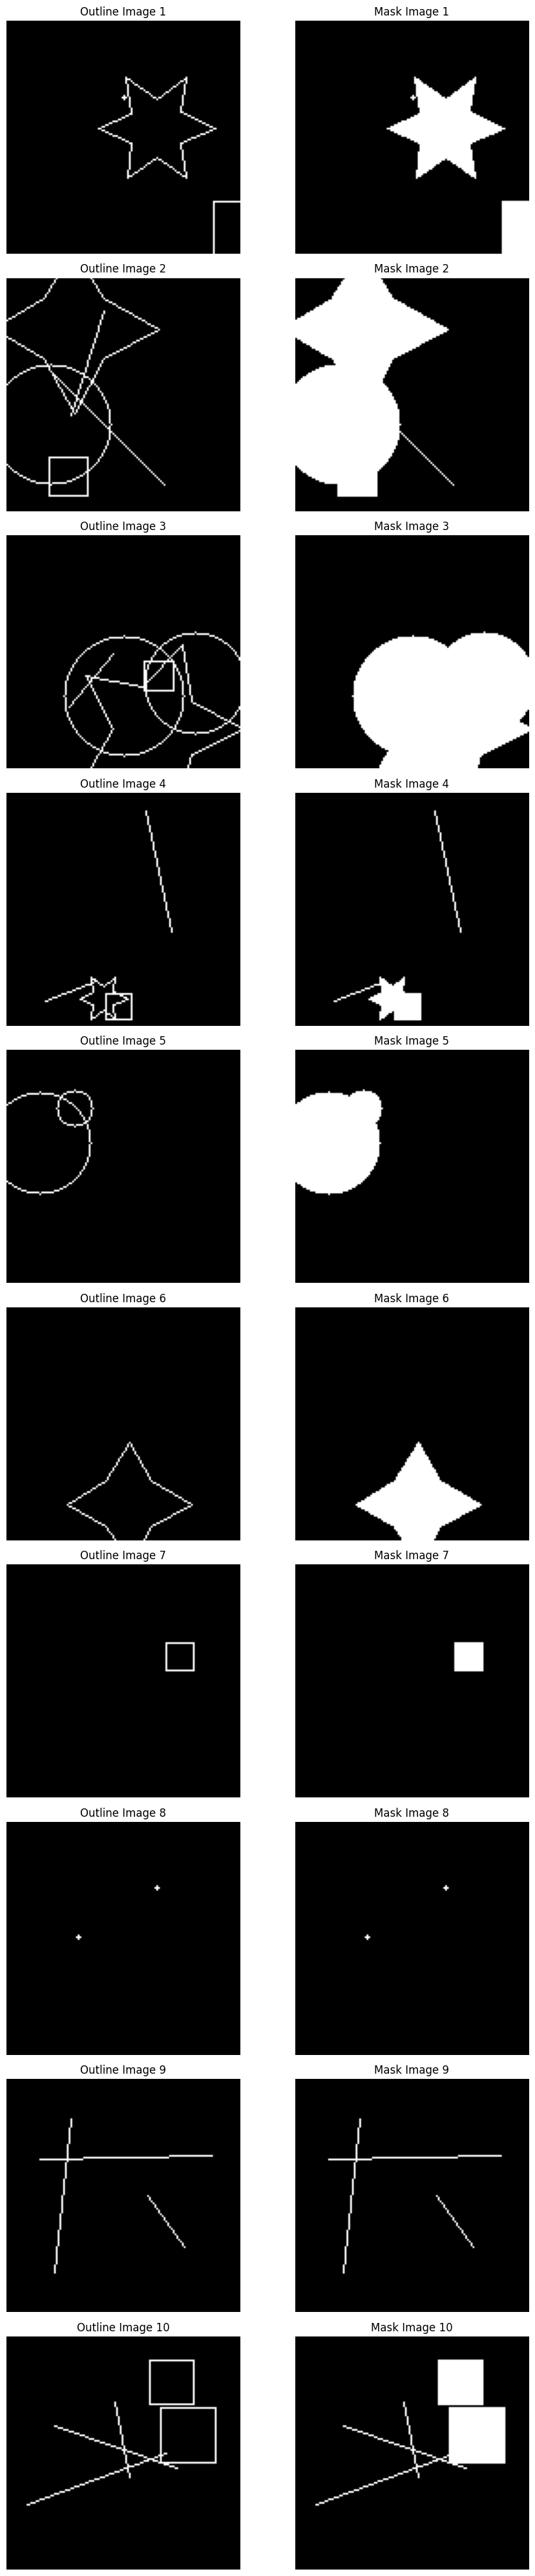

In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt


# Random dataset of shape outlines with masks
def generate_dataset(output_dir, num_samples, image_size):
    outline_dir = os.path.join(output_dir, "outlines")
    mask_dir = os.path.join(output_dir, "masks")
    os.makedirs(outline_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)

    shape_types = ["dot", "line", "square", "quadrilateral", "circle", "star"]

    for i in range(num_samples):
        
        canvas = np.zeros((image_size, image_size), dtype=np.uint8)
        mask = np.zeros((image_size, image_size), dtype=np.uint8)

        for _ in range(np.random.randint(1, 6)):  
            shape_type = np.random.choice(shape_types)

            x, y = np.random.randint(10, image_size - 10), np.random.randint(10, image_size - 10)
            size = np.random.randint(10, 50)
            angle = np.random.randint(0, 360)
            num_sides = np.random.randint(3, 8)

            if shape_type == "dot":
                cv.circle(canvas, (x, y), 1, 255, -1)  
                cv.circle(mask, (x, y), 1, 255, -1) 
            elif shape_type == "line":
                x2, y2 = np.random.randint(10, image_size - 10), np.random.randint(10, image_size - 10)
                cv.line(canvas, (x, y), (x2, y2), 255, 1)
                cv.line(mask, (x, y), (x2, y2), 255, 1)
            elif shape_type == "square":
                cv.rectangle(canvas, (x, y), (x + size, y + size), 255, 1)
                cv.rectangle(mask, (x, y), (x + size, y + size), 255, -1)
            elif shape_type == "quadrilateral":
                points = np.array([[x, y], [x + size, y], [x + size, y + size], [x, y + size]], np.int32)
                cv.polylines(canvas, [points], isClosed=True, color=255, thickness=1)
                cv.fillPoly(mask, [points], 255)  
            elif shape_type == "circle":
                cv.circle(canvas, (x, y), size, 255, 1)
                cv.circle(mask, (x, y), size, 255, -1) 
            elif shape_type == "star":
                points = []
                for j in range(0, num_sides * 2, 2):
                    points.append((x + size * np.cos(j * np.pi / num_sides),
                                   y + size * np.sin(j * np.pi / num_sides)))
                    points.append((x + size / 2 * np.cos((j + 1) * np.pi / num_sides),
                                   y + size / 2 * np.sin((j + 1) * np.pi / num_sides)))
                cv.polylines(canvas, [np.array(points, np.int32)], isClosed=True, color=255, thickness=1)
                cv.fillPoly(mask, [np.array(points, np.int32)], 255)  

        cv.imwrite(os.path.join(outline_dir, f"sample_{i+1}_outline.png"), canvas)
        cv.imwrite(os.path.join(mask_dir, f"sample_{i+1}_mask.png"), mask)


# Parameters
output_directory = "fake_dataset"
num_samples = 1000
image_size = 128

generate_dataset(output_directory, num_samples, image_size)

def display_images(outline_dir, mask_dir, num_images):
    
    outline_image_files = sorted([f for f in os.listdir(outline_dir) if f.endswith('_outline.png')])
    mask_image_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('_mask.png')])

    # Display images
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 4*num_images))
    for i in range(num_images):

        outline_image = cv.imread(os.path.join(outline_dir, outline_image_files[i]), cv.IMREAD_GRAYSCALE)
        mask_image = cv.imread(os.path.join(mask_dir, mask_image_files[i]), cv.IMREAD_GRAYSCALE)

        axes[i, 0].imshow(outline_image, cmap='gray')
        axes[i, 0].set_title('Outline Image {}'.format(i+1))
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_image, cmap='gray')
        axes[i, 1].set_title('Mask Image {}'.format(i+1))
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

outline_directory = os.path.join(output_directory, "outlines")
mask_directory = os.path.join(output_directory, "masks")

display_images(outline_directory, mask_directory, 10)

In [4]:
import cv2 as cv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

class AugmentedShapeDataset(Dataset):
    def __init__(self, outline_files, mask_files, outline_dir, mask_dir, transform=None):
        self.outline_files = outline_files
        self.mask_files = mask_files
        self.outline_dir = outline_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.outline_files)

    def __getitem__(self, idx):
        outline_path = os.path.join(self.outline_dir, self.outline_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        outline_image = cv.imread(outline_path, cv.IMREAD_GRAYSCALE)
        mask_image = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)

        # To tensors
        outline_image = torch.from_numpy(outline_image).float().unsqueeze(0) / 255.0
        mask_image = torch.from_numpy(mask_image).float().unsqueeze(0) / 255.0

        if self.transform:
            outline_image = self.transform(outline_image)
            mask_image = self.transform(mask_image)

        return outline_image, mask_image

def train_test_split_dataset(outline_dir, mask_dir, test_size=0.2):
    outline_files = sorted(os.listdir(outline_dir))
    mask_files = sorted(os.listdir(mask_dir))
    outline_train, outline_test, mask_train, mask_test = train_test_split(
        outline_files, mask_files, test_size=test_size, random_state=42)
    return outline_train, outline_test, mask_train, mask_test

# UNet architecture
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSample, self).__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSample, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], 1)
       return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_convolution_1 = DownSample(1, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def forward(self, x):
       down_1, p1 = self.down_convolution_1(x)
       down_2, p2 = self.down_convolution_2(p1)
       down_3, p3 = self.down_convolution_3(p2)
       down_4, p4 = self.down_convolution_4(p3)

       b = self.bottle_neck(p4)

       up_1 = self.up_convolution_1(b, down_4)
       up_2 = self.up_convolution_2(up_1, down_3)
       up_3 = self.up_convolution_3(up_2, down_2)
       up_4 = self.up_convolution_4(up_3, down_1)

       out = self.out(up_4)
       return out

def accuracy(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()
    correct = (y_pred == y_true).float().sum()
    total = y_true.numel()
    return correct / total

def dice_score(y_true, y_pred):
    smooth = 1e-8
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() + smooth
    return (2 * intersection) / union

# Training parameters
num_epochs = 4
batch_size = 32
learning_rate = 0.001

# Data augmentation
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0), ratio=(0.8, 1.2)),
])

outline_dir = "fake_dataset/outlines"
mask_dir = "fake_dataset/masks"

outline_train, outline_test, mask_train, mask_test = train_test_split_dataset(outline_dir, mask_dir)

train_dataset = AugmentedShapeDataset(outline_train, mask_train, outline_dir, mask_dir, transform=augmentation_transform)
test_dataset = AugmentedShapeDataset(outline_test, mask_test, outline_dir, mask_dir)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = UNet()
criterion = nn.BCEWithLogitsLoss()  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    total_accuracy = 0.0
    total_dice_score = 0.0

    model.train()

    for outlines, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(outlines)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy(masks, torch.sigmoid(outputs)).item()
        total_dice_score += dice_score(masks, torch.sigmoid(outputs)).item()

    average_loss = total_loss / len(train_loader)
    average_accuracy = total_accuracy / len(train_loader)
    average_dice_score = total_dice_score / len(train_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {average_accuracy:.4f}, Dice Score: {average_dice_score:.4f}')

torch.save(model.state_dict(), 'unet_model_segmentation.pth')

Epoch [1/4], Loss: 0.5119, Accuracy: 0.8018, Dice Score: 0.2491
Epoch [2/4], Loss: 0.4286, Accuracy: 0.8134, Dice Score: 0.2434
Epoch [3/4], Loss: 0.4185, Accuracy: 0.8172, Dice Score: 0.2421
Epoch [4/4], Loss: 0.4176, Accuracy: 0.8169, Dice Score: 0.2522


Test Results - Loss: 0.3506, Accuracy: 0.8506, Dice Score: 0.3471


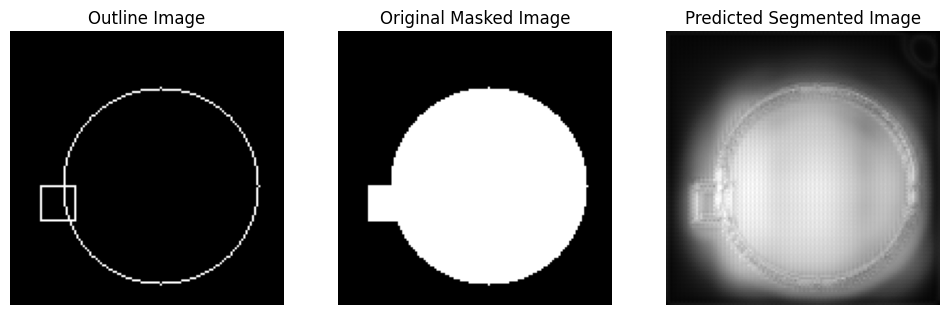

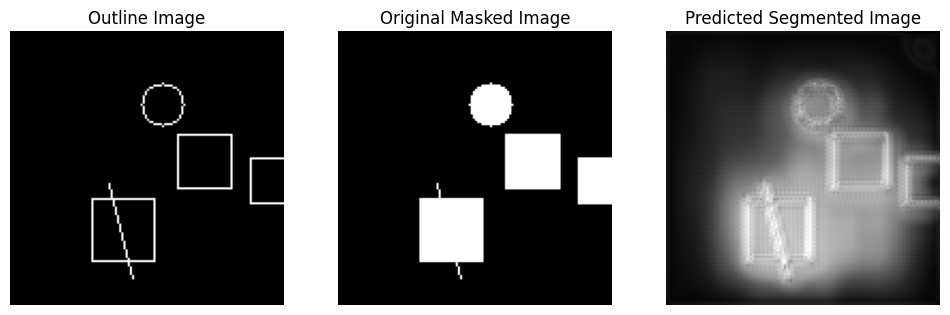

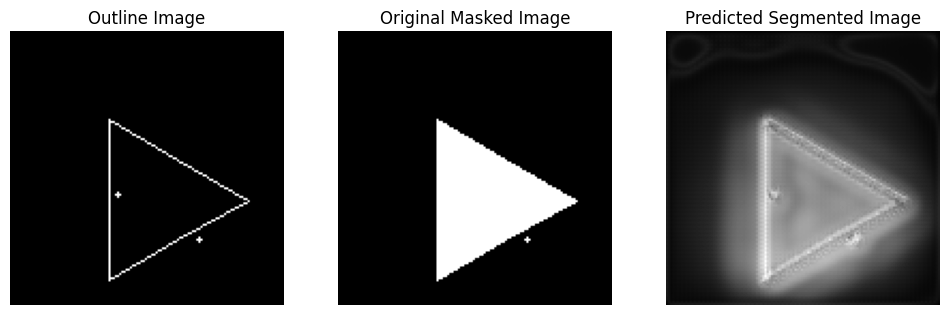

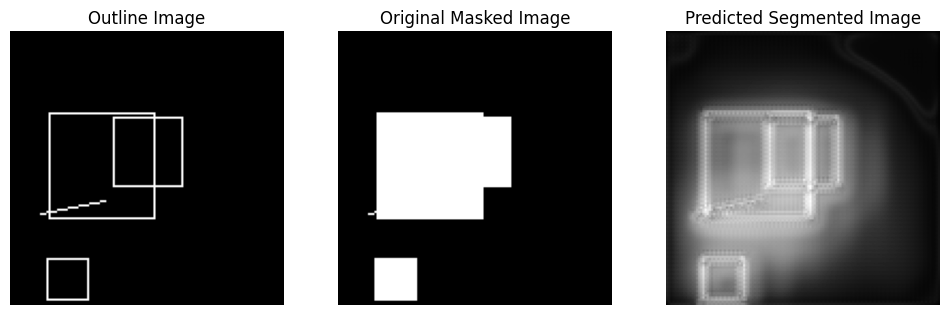

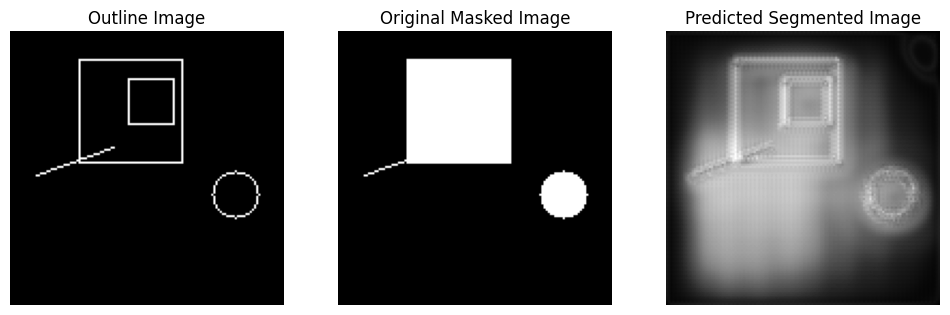

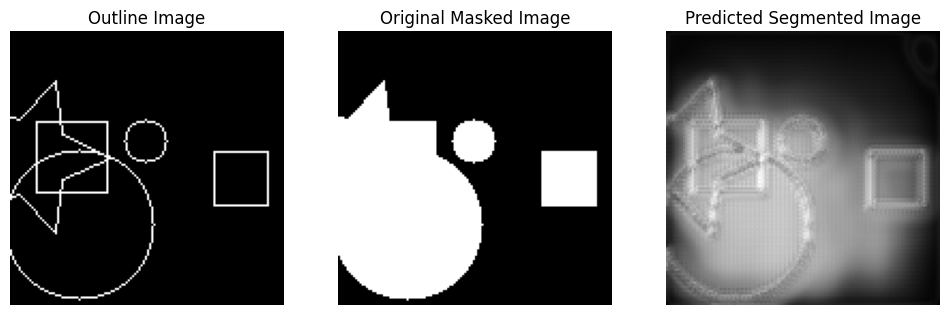

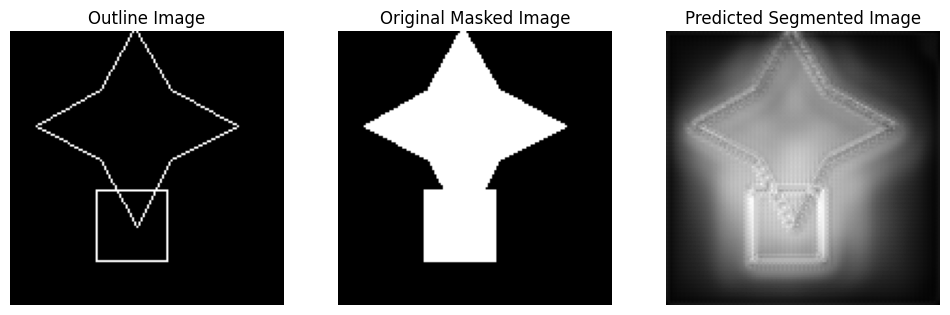

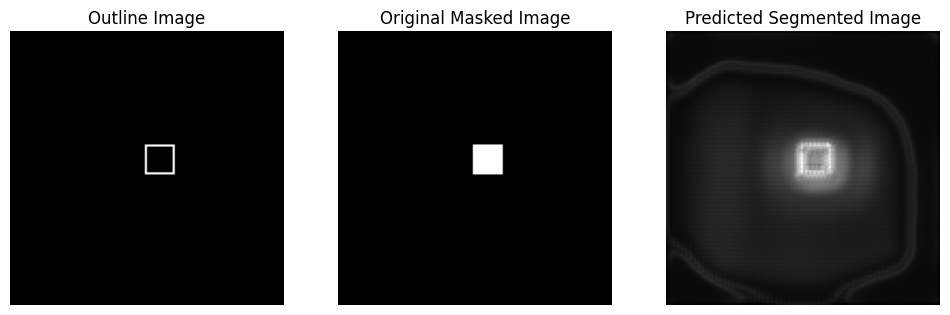

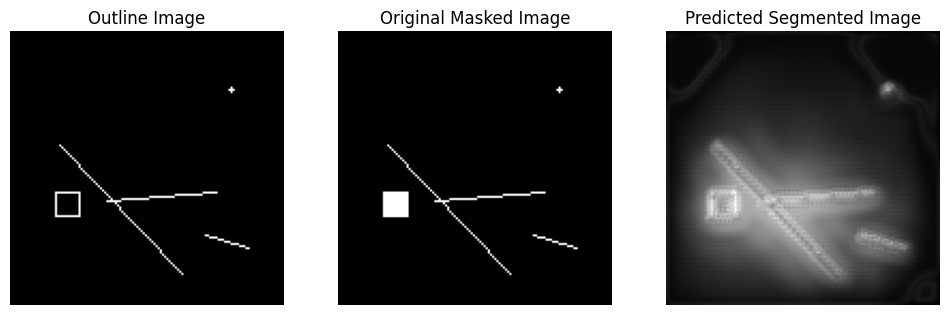

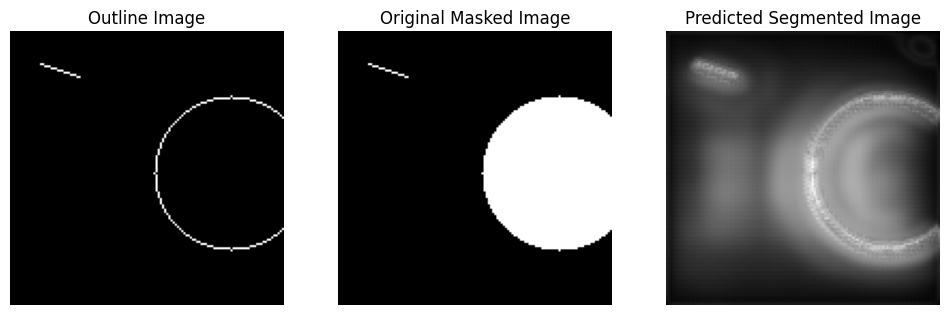

In [5]:
model = UNet()
model.load_state_dict(torch.load('unet_model_segmentation.pth'))
model.eval()

def accuracy(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()
    correct = (y_pred == y_true).float().sum()
    total = y_true.numel()
    return correct / total

def dice_score(y_true, y_pred):
    smooth = 1e-8
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() + smooth
    return (2 * intersection) / union

total_loss = 0.0
total_accuracy = 0.0
total_dice_score = 0.0

# Test dataset
for outlines, masks in test_loader:
    with torch.no_grad():
        outputs = model(outlines)
        loss = criterion(outputs, masks)

        total_loss += loss.item()
        total_accuracy += accuracy(masks, torch.sigmoid(outputs)).item()
        total_dice_score += dice_score(masks, torch.sigmoid(outputs)).item()

average_loss = total_loss / len(test_loader)
average_accuracy = total_accuracy / len(test_loader)
average_dice_score = total_dice_score / len(test_loader)

print(f'Test Results - Loss: {average_loss:.4f}, Accuracy: {average_accuracy:.4f}, Dice Score: {average_dice_score:.4f}')

display_count = 0

for outlines, masks in test_loader:

    with torch.no_grad():
        outputs = model(outlines)
        predicted_masks = torch.sigmoid(outputs)

    for i in range(len(outlines)):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(outlines[i].squeeze().numpy(), cmap='gray')
        plt.title('Outline Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].squeeze().numpy(), cmap='gray')
        plt.title('Original Masked Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_masks[i].squeeze().numpy(), cmap='gray')
        plt.title('Predicted Segmented Image')
        plt.axis('off')

        plt.show()

        display_count += 1

        if display_count == 10:
            break

    if display_count == 10:
        break


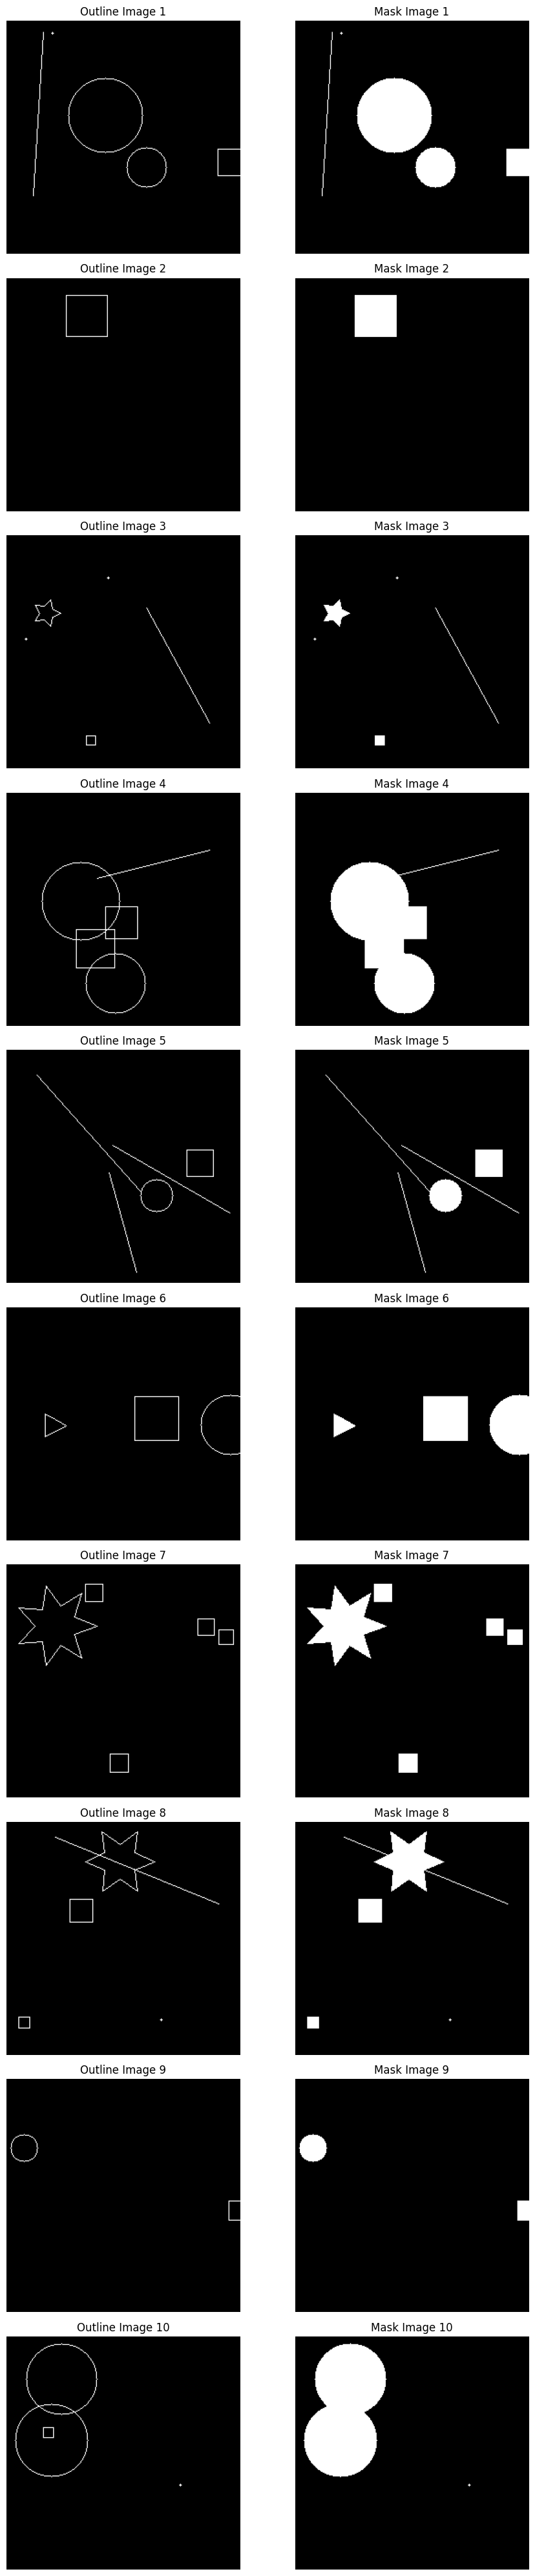

In [6]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt


# Random dataset of shape outlines with masks
def generate_dataset(output_dir, num_samples, image_size):
    outline_dir = os.path.join(output_dir, "outlines")
    mask_dir = os.path.join(output_dir, "masks")
    os.makedirs(outline_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)

    shape_types = ["dot", "line", "square", "quadrilateral", "circle", "star"]

    for i in range(num_samples):

        canvas = np.zeros((image_size, image_size), dtype=np.uint8)
        mask = np.zeros((image_size, image_size), dtype=np.uint8)

        for _ in range(np.random.randint(1, 6)): 
            shape_type = np.random.choice(shape_types)

            x, y = np.random.randint(10, image_size - 10), np.random.randint(10, image_size - 10)
            size = np.random.randint(10, 50)
            angle = np.random.randint(0, 360)
            num_sides = np.random.randint(3, 8)

            if shape_type == "dot":
                cv.circle(canvas, (x, y), 1, 255, -1)  
                cv.circle(mask, (x, y), 1, 255, -1) 
            elif shape_type == "line":
                x2, y2 = np.random.randint(10, image_size - 10), np.random.randint(10, image_size - 10)
                cv.line(canvas, (x, y), (x2, y2), 255, 1)
                cv.line(mask, (x, y), (x2, y2), 255, 1)
            elif shape_type == "square":
                cv.rectangle(canvas, (x, y), (x + size, y + size), 255, 1)
                cv.rectangle(mask, (x, y), (x + size, y + size), 255, -1)
            elif shape_type == "quadrilateral":
                points = np.array([[x, y], [x + size, y], [x + size, y + size], [x, y + size]], np.int32)
                cv.polylines(canvas, [points], isClosed=True, color=255, thickness=1)
                cv.fillPoly(mask, [points], 255) 
            elif shape_type == "circle":
                cv.circle(canvas, (x, y), size, 255, 1)
                cv.circle(mask, (x, y), size, 255, -1) 
            elif shape_type == "star":
                points = []
                for j in range(0, num_sides * 2, 2):
                    points.append((x + size * np.cos(j * np.pi / num_sides),
                                   y + size * np.sin(j * np.pi / num_sides)))
                    points.append((x + size / 2 * np.cos((j + 1) * np.pi / num_sides),
                                   y + size / 2 * np.sin((j + 1) * np.pi / num_sides)))
                cv.polylines(canvas, [np.array(points, np.int32)], isClosed=True, color=255, thickness=1)
                cv.fillPoly(mask, [np.array(points, np.int32)], 255)  

        cv.imwrite(os.path.join(outline_dir, f"sample_{i+1}_outline.png"), canvas)
        cv.imwrite(os.path.join(mask_dir, f"sample_{i+1}_mask.png"), mask)

# Parameters
output_directory = "fake_dataset1"
num_samples = 1000
image_size = 256

generate_dataset(output_directory, num_samples, image_size)

def display_images(outline_dir, mask_dir, num_images):

    outline_image_files = sorted([f for f in os.listdir(outline_dir) if f.endswith('_outline.png')])
    mask_image_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('_mask.png')])

    fig, axes = plt.subplots(num_images, 2, figsize=(10, 4*num_images))
    for i in range(num_images):
 
        outline_image = cv.imread(os.path.join(outline_dir, outline_image_files[i]), cv.IMREAD_GRAYSCALE)
        mask_image = cv.imread(os.path.join(mask_dir, mask_image_files[i]), cv.IMREAD_GRAYSCALE)

        axes[i, 0].imshow(outline_image, cmap='gray')
        axes[i, 0].set_title('Outline Image {}'.format(i+1))
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_image, cmap='gray')
        axes[i, 1].set_title('Mask Image {}'.format(i+1))
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

outline_directory = os.path.join(output_directory, "outlines")
mask_directory = os.path.join(output_directory, "masks")

display_images(outline_directory, mask_directory, 10)

In [7]:
import cv2 as cv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ExponentialLR

class AugmentedShapeDataset(Dataset):
    def __init__(self, outline_files, mask_files, outline_dir, mask_dir, transform=None):
        self.outline_files = outline_files
        self.mask_files = mask_files
        self.outline_dir = outline_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.outline_files)

    def __getitem__(self, idx):
        outline_path = os.path.join(self.outline_dir, self.outline_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        outline_image = cv.imread(outline_path, cv.IMREAD_GRAYSCALE)
        mask_image = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)

        # To tensors
        outline_image = torch.from_numpy(outline_image).float().unsqueeze(0) / 255.0
        mask_image = torch.from_numpy(mask_image).float().unsqueeze(0) / 255.0

        if self.transform:
            outline_image = self.transform(outline_image)
            mask_image = self.transform(mask_image)

        return outline_image, mask_image

def train_test_split_dataset(outline_dir, mask_dir, test_size=0.2):
    outline_files = sorted(os.listdir(outline_dir))
    mask_files = sorted(os.listdir(mask_dir))
    outline_train, outline_test, mask_train, mask_test = train_test_split(
        outline_files, mask_files, test_size=test_size, random_state=42)
    return outline_train, outline_test, mask_train, mask_test

# UNet architecture
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSample, self).__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSample, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], 1)
       return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_convolution_1 = DownSample(1, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def forward(self, x):
       down_1, p1 = self.down_convolution_1(x)
       down_2, p2 = self.down_convolution_2(p1)
       down_3, p3 = self.down_convolution_3(p2)
       down_4, p4 = self.down_convolution_4(p3)

       b = self.bottle_neck(p4)

       up_1 = self.up_convolution_1(b, down_4)
       up_2 = self.up_convolution_2(up_1, down_3)
       up_3 = self.up_convolution_3(up_2, down_2)
       up_4 = self.up_convolution_4(up_3, down_1)

       out = self.out(up_4)
       return out

def accuracy(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()
    correct = (y_pred == y_true).float().sum()
    total = y_true.numel()
    return correct / total

def dice_score(y_true, y_pred):
    smooth = 1e-8
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() + smooth
    return (2 * intersection) / union

# Training parameters
num_epochs = 14
batch_size = 32
learning_rate = 0.1

augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0), ratio=(0.8, 1.2)),
])

outline_dir = "fake_dataset1/outlines"
mask_dir = "fake_dataset1/masks"

outline_train, outline_test, mask_train, mask_test = train_test_split_dataset(outline_dir, mask_dir)

train_dataset = AugmentedShapeDataset(outline_train, mask_train, outline_dir, mask_dir, transform=augmentation_transform)
test_dataset = AugmentedShapeDataset(outline_test, mask_test, outline_dir, mask_dir)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = UNet()
criterion = nn.BCEWithLogitsLoss()  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Exponential learning rate scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    total_accuracy = 0.0
    total_dice_score = 0.0

    model.train()

    for outlines, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(outlines)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy(masks, torch.sigmoid(outputs)).item()
        total_dice_score += dice_score(masks, torch.sigmoid(outputs)).item()

    average_loss = total_loss / len(train_loader)
    average_accuracy = total_accuracy / len(train_loader)
    average_dice_score = total_dice_score / len(train_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {average_accuracy:.4f}, Dice Score: {average_dice_score:.4f}')

    scheduler.step()

torch.save(model.state_dict(), 'unet_model_segmentation1.pth')

Epoch [1/14], Loss: 0.2587, Accuracy: 0.9309, Dice Score: 0.0708
Epoch [2/14], Loss: 0.1995, Accuracy: 0.9448, Dice Score: 0.0718
Epoch [3/14], Loss: 0.1920, Accuracy: 0.9455, Dice Score: 0.0757
Epoch [4/14], Loss: 0.1930, Accuracy: 0.9450, Dice Score: 0.0758
Epoch [5/14], Loss: 0.1897, Accuracy: 0.9452, Dice Score: 0.0831
Epoch [6/14], Loss: 0.1919, Accuracy: 0.9452, Dice Score: 0.0742
Epoch [7/14], Loss: 0.1890, Accuracy: 0.9455, Dice Score: 0.0766
Epoch [8/14], Loss: 0.1921, Accuracy: 0.9449, Dice Score: 0.0777
Epoch [9/14], Loss: 0.1901, Accuracy: 0.9448, Dice Score: 0.0806
Epoch [10/14], Loss: 0.1924, Accuracy: 0.9449, Dice Score: 0.0752
Epoch [11/14], Loss: 0.1905, Accuracy: 0.9448, Dice Score: 0.0825
Epoch [12/14], Loss: 0.1889, Accuracy: 0.9453, Dice Score: 0.0806
Epoch [13/14], Loss: 0.1911, Accuracy: 0.9449, Dice Score: 0.0781
Epoch [14/14], Loss: 0.1879, Accuracy: 0.9454, Dice Score: 0.0846


Test Results - Loss: 0.1549, Accuracy: 0.9481, Dice Score: 0.1269


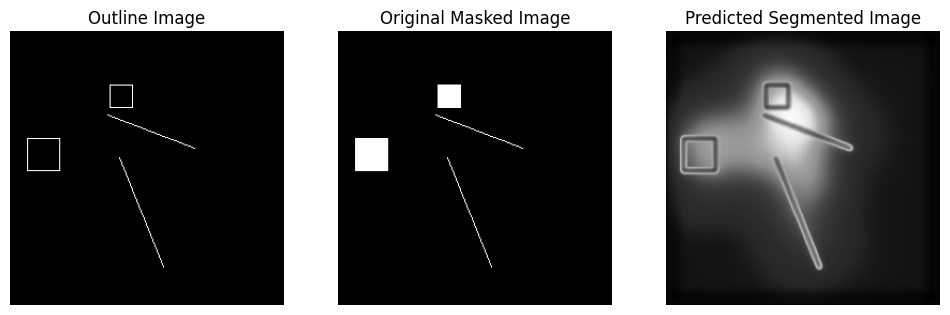

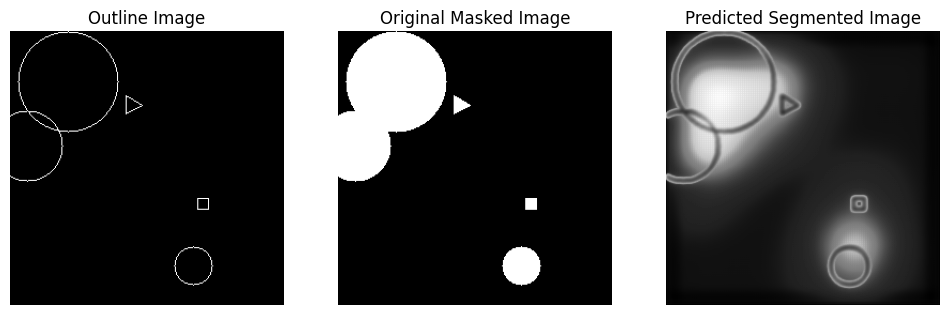

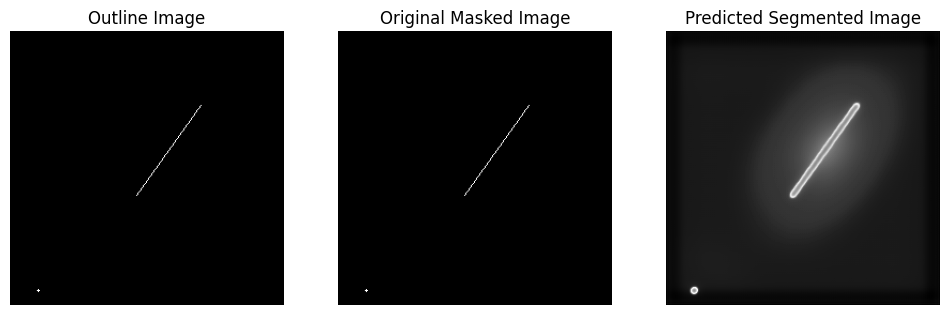

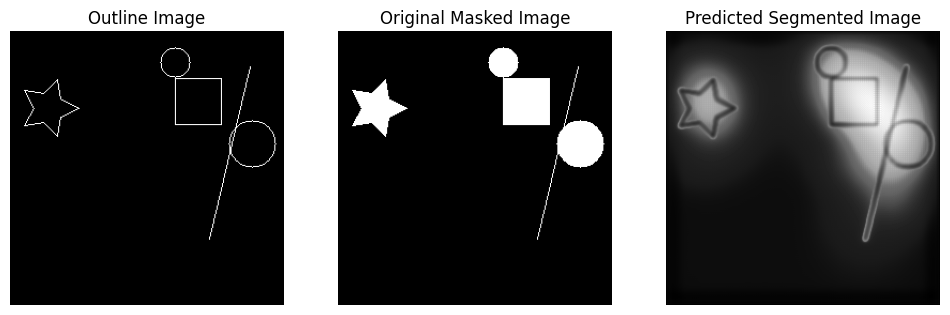

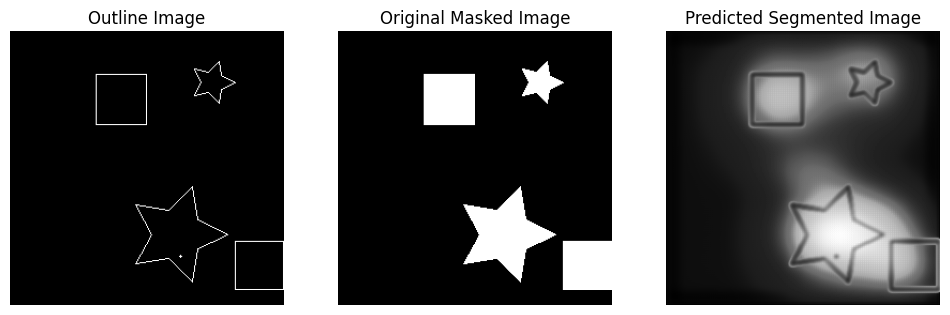

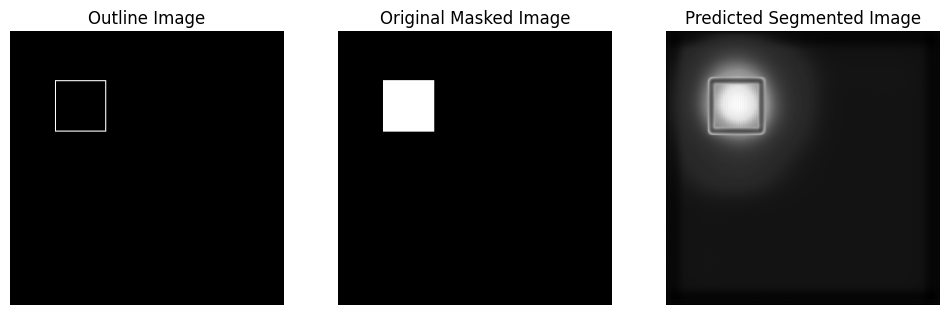

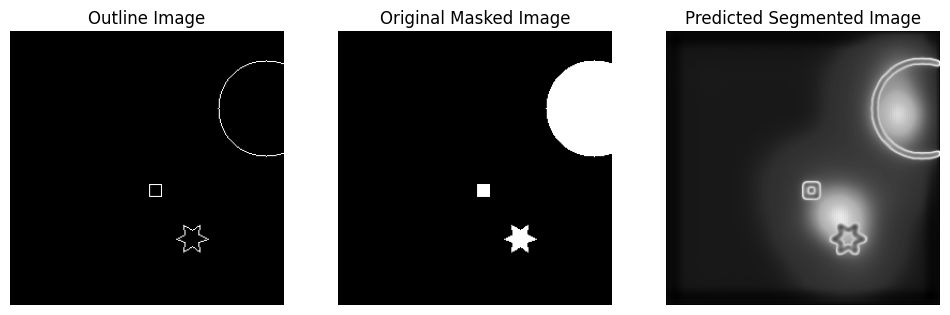

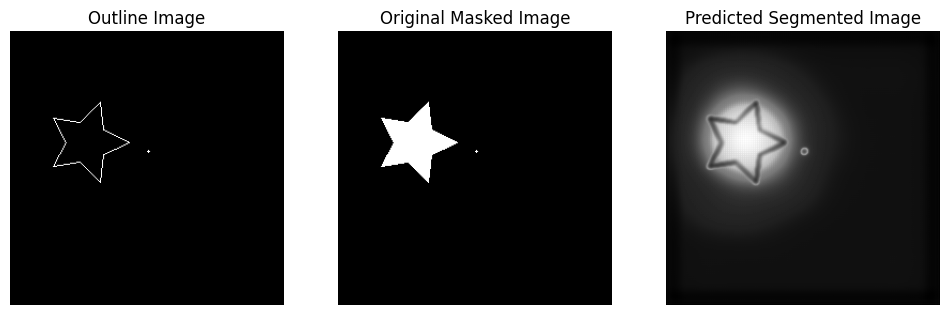

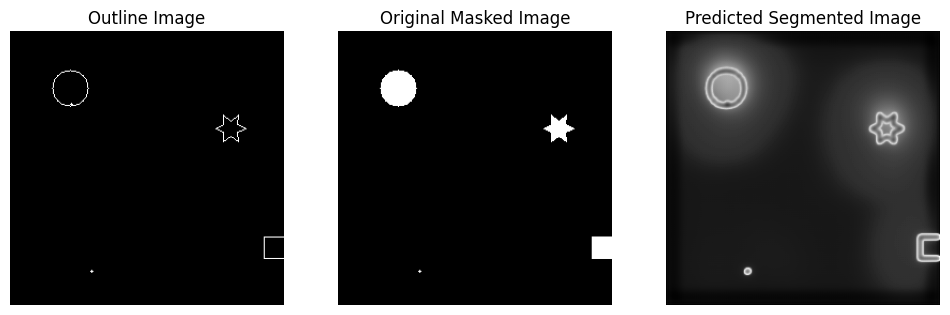

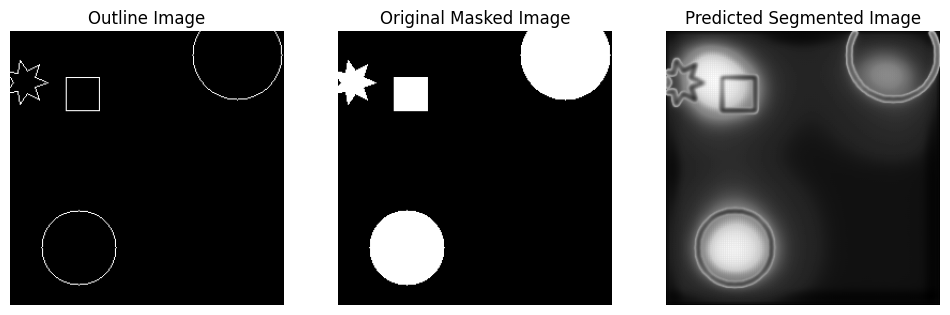

In [8]:
model = UNet()
model.load_state_dict(torch.load('unet_model_segmentation1.pth'))
model.eval()

def accuracy(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()
    correct = (y_pred == y_true).float().sum()
    total = y_true.numel()
    return correct / total

def dice_score(y_true, y_pred):
    smooth = 1e-8
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() + smooth
    return (2 * intersection) / union

total_loss = 0.0
total_accuracy = 0.0
total_dice_score = 0.0

for outlines, masks in test_loader:
    with torch.no_grad():
        outputs = model(outlines)
        loss = criterion(outputs, masks)

        total_loss += loss.item()
        total_accuracy += accuracy(masks, torch.sigmoid(outputs)).item()
        total_dice_score += dice_score(masks, torch.sigmoid(outputs)).item()

average_loss = total_loss / len(test_loader)
average_accuracy = total_accuracy / len(test_loader)
average_dice_score = total_dice_score / len(test_loader)

print(f'Test Results - Loss: {average_loss:.4f}, Accuracy: {average_accuracy:.4f}, Dice Score: {average_dice_score:.4f}')

display_count = 0

for outlines, masks in test_loader:
    
    with torch.no_grad():
        outputs = model(outlines)
        predicted_masks = torch.sigmoid(outputs)

    for i in range(len(outlines)):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(outlines[i].squeeze().numpy(), cmap='gray')
        plt.title('Outline Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].squeeze().numpy(), cmap='gray')
        plt.title('Original Masked Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_masks[i].squeeze().numpy(), cmap='gray')
        plt.title('Predicted Segmented Image')
        plt.axis('off')

        plt.show()

        display_count += 1

        if display_count == 10:
            break

    if display_count == 10:
        break